In [6]:
result_path = "/work/jiaqi/DiffMol/3d_synth_noised_log/test-20230424-0150/smiles_gt_pred.txt"

with open(result_path) as f:
    lines = f.readlines()
smiles_gt_pred = []
for line in lines:
    smiles, gt, pred = line.strip().split()
    smiles_gt_pred.append([smiles, int(gt), int(pred)])
print(f'number of entries: {len(smiles_gt_pred)}')

import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm.auto import tqdm
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

smiles_list = [s[0] for s in smiles_gt_pred]
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
# Generate Morgan fingerprints for each molecule
fps = [Chem.RDKFingerprint(mol) for mol in tqdm(mols)]
print(fps[0], np.array(list(fps[0].ToBitString())).astype(int).shape)
# Convert the binary fingerprints to numpy arrays
fp_arrays = [np.array(list(fp.ToBitString())).astype(int) for fp in tqdm(fps)]
print(fp_arrays[0])
fp_arrays = np.vstack(fp_arrays)
print(fp_arrays.shape)
pred_labels = np.array([s[2] for s in smiles_gt_pred])
print(pred_labels.shape)
gt_labels = np.array([s[1] for s in smiles_gt_pred])

number of entries: 57894


  0%|          | 0/57894 [00:00<?, ?it/s]

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fbaa5b21a50> (2048,)


  0%|          | 0/57894 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
(57894, 2048)
(57894,)


In [7]:
(fps[0])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(fp_arrays)

# Perform t-SNE to visualize the embeddings in 2D
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=10)
X_tsne = tsne.fit_transform(X_pca)

# Plot the embeddings with different colors for each label
# plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], c='blue', label='Label 0')
# plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], c='red', label='Label 1')
# plt.legend()
# plt.title('pred labels')
# plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 57894 samples in 0.018s...
[t-SNE] Computed neighbors for 57894 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57894
[t-SNE] Computed conditional probabilities for sample 2000 / 57894
[t-SNE] Computed conditional probabilities for sample 3000 / 57894
[t-SNE] Computed conditional probabilities for sample 4000 / 57894
[t-SNE] Computed conditional probabilities for sample 5000 / 57894
[t-SNE] Computed conditional probabilities for sample 6000 / 57894
[t-SNE] Computed conditional probabilities for sample 7000 / 57894
[t-SNE] Computed conditional probabilities for sample 8000 / 57894
[t-SNE] Computed conditional probabilities for sample 9000 / 57894
[t-SNE] Computed conditional probabilities for sample 10000 / 57894
[t-SNE] Computed conditional probabilities for sample 11000 / 57894
[t-SNE] Computed conditional probabilities for sample 12000 / 57894
[t-SNE] Computed conditional probabilities for sam

28885 29009


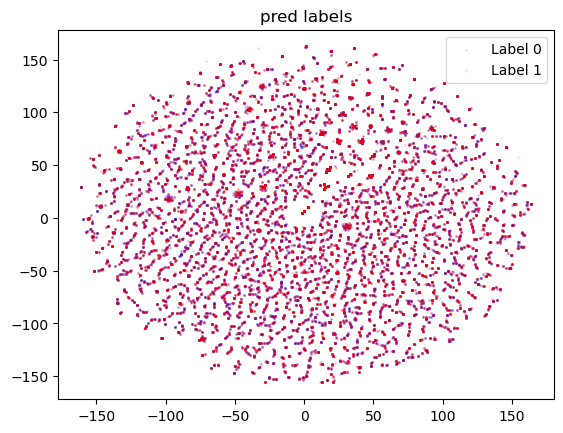

28962 28932


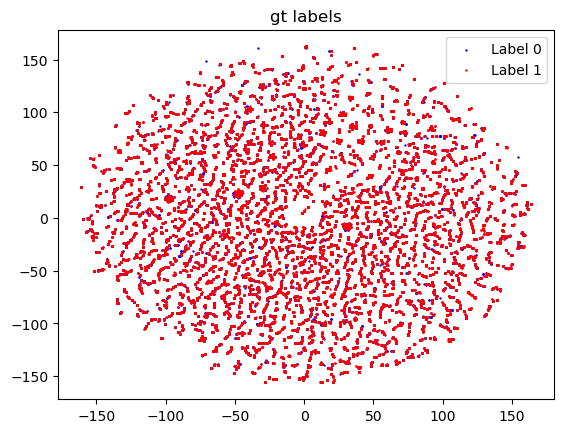

In [17]:
y = pred_labels
print(np.sum(y==1), np.sum(y==0))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], c='blue', label='Label 0', s=1, alpha=0.1)
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], c='red', label='Label 1', s=1, alpha=0.1)
plt.legend()
plt.title('pred labels')
plt.show()

y = gt_labels
print(np.sum(y==1), np.sum(y==0))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], c='blue', label='Label 0', s=0.5)
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], c='red', label='Label 1', s=0.5)
plt.legend()
plt.title('gt labels')
plt.show()

In [17]:

import argparse
import os

import numpy as np
from rdkit import Chem
from rdkit import RDLogger
import torch
from tqdm.auto import tqdm
from glob import glob
from collections import Counter

from utils.evaluation import eval_atom_type, scoring_func, analyze, eval_bond_length

from utils import misc

from utils import reconstruct

from utils import transforms

from utils.evaluation.docking_qvina import QVinaDockingTask

from utils.evaluation.docking_vina import VinaDockingTask

from utils.visualize import MolTo3DView
from utils.transforms import MAP_INDEX_TO_ATOM_TYPE_AROMATIC
import random
from rdkit import Chem
from rdkit.Geometry import Point3D

torch.set_num_threads(1)
def print_dict(d, logger):
    for k, v in d.items():
        if v is not None:
            logger.info(f'{k}:\t{v:.4f}')
        else:
            logger.info(f'{k}:\tNone')


def print_ring_ratio(all_ring_sizes, logger):
    for ring_size in range(3, 10):
        n_mol = 0
        for counter in all_ring_sizes:
            if ring_size in counter:
                n_mol += 1
        logger.info(f'ring size: {ring_size} ratio: {n_mol / len(all_ring_sizes):.3f}')

def construct_mol(coords):
    atom_types = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
    mol = Chem.RWMol()
    num = len(coords)
    for i in range(num):
        atom = Chem.Atom(random.choice(atom_types))
        mol.AddAtom(atom)
    mol = mol.GetMol()
    conf = Chem.Conformer(num)
    mol.AddConformer(conf)
    for i in range(num):
        x, y, z = [a.item() for a in coords[i]]
        mol.GetConformer().SetAtomPosition(i, Point3D(x, y, z))
    
    return mol
        
if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # parser.add_argument('sample_path', type=str)
    # parser.add_argument('--verbose', type=eval, default=False)
    # parser.add_argument('--eval_step', type=int, default=-1)
    # parser.add_argument('--eval_num_examples', type=int, default=None)
    # parser.add_argument('--save', type=eval, default=True)
    # parser.add_argument('--protein_root', type=str, default='./data/crossdocked_v1.1_rmsd1.0')
    # parser.add_argument('--atom_enc_mode', type=str, default='add_aromatic')
    # parser.add_argument('--docking_mode', type=str, choices=['qvina', 'vina_score', 'vina_dock', 'none'])
    # parser.add_argument('--exhaustiveness', type=int, default=16)
    # args = parser.parse_args()
    
    sample_path = 'results_guided/outputs_guided_crsd_1e-3_500'
    verbose = False
    eval_num_examples = 1
#     eval_step = -1
    atom_enc_mode = 'add_aromatic'
    print(1)

    result_path = os.path.join(sample_path, 'eval_results')
    os.makedirs(result_path, exist_ok=True)
    logger = misc.get_logger('evaluate', log_dir=result_path)
    if not verbose:
        RDLogger.DisableLog('rdApp.*')

    # Load generated data
    results_fn_list = glob(os.path.join(sample_path, '*result_*.pt'))
    results_fn_list = sorted(results_fn_list, key=lambda x: int(os.path.basename(x)[:-3].split('_')[-1]))
    if eval_num_examples is not None:
        results_fn_list = results_fn_list[:eval_num_examples]
    num_examples = len(results_fn_list)
    logger.info(f'Load generated data done! {num_examples} examples in total.')

    num_samples = 0
    all_mol_stable, all_atom_stable, all_n_atom = 0, 0, 0
    n_recon_success, n_eval_success, n_complete = 0, 0, 0
    results = []
    all_pair_dist, all_bond_dist = [], []
    all_atom_types = Counter()
    success_pair_dist, success_atom_types = [], Counter()
    # print(results_fn_list, len(results_fn_list))
    for eval_step in [-1, -10, 10, 30]:
        mid_res = []
        for example_idx, r_name in enumerate(tqdm(results_fn_list, desc='Eval')):
            r = torch.load(r_name)  # ['data', 'pred_ligand_pos', 'pred_ligand_v', 'pred_ligand_pos_traj', 'pred_ligand_v_traj']
            all_pred_ligand_pos = r['pred_ligand_pos_traj']  # [num_samples, num_steps, num_atoms, 3]
            all_pred_ligand_v = r['pred_ligand_v_traj']
            num_samples += len(all_pred_ligand_pos)
            # print(len(all_pred_ligand_pos), len(all_pred_ligand_pos[0]), len(all_pred_ligand_pos[0][0]), len(all_pred_ligand_pos[0][0][0]), len(all_pred_ligand_v), len(all_pred_ligand_v[0]), (all_pred_ligand_v[0][0]))
            # input()
            for sample_idx, (pred_pos, pred_v) in enumerate(zip(all_pred_ligand_pos, all_pred_ligand_v)):
                pred_pos, pred_v = pred_pos[eval_step], pred_v[eval_step]
#                 print(pred_pos.shape, len(pred_pos))
#                 input()
                # stability check
                pred_atom_type = transforms.get_atomic_number_from_index(pred_v, mode=atom_enc_mode)
                all_atom_types += Counter(pred_atom_type)
                r_stable = analyze.check_stability(pred_pos, pred_atom_type)
                all_mol_stable += r_stable[0]
                all_atom_stable += r_stable[1]
                all_n_atom += r_stable[2]

                pair_dist = eval_bond_length.pair_distance_from_pos_v(pred_pos, pred_atom_type)
                all_pair_dist += pair_dist
#                 if eval_step == 0:
#                     print(pred_atom_type)
#                     print([MAP_INDEX_TO_ATOM_TYPE_AROMATIC[idx][0] for idx in pred_atom_type])
#                     input()
                # reconstruction
                try:
                    pred_aromatic = transforms.is_aromatic_from_index(pred_v, mode=atom_enc_mode)
                    if eval_step == 0:
                        mol = construct_mol(pred_pos)
                        mid_res.append(mol)
                    mol = reconstruct.reconstruct_from_generated(pred_pos, pred_atom_type, pred_aromatic)
                   
                    smiles = Chem.MolToSmiles(mol)
                    # print(smiles)
                except reconstruct.MolReconsError:
                    if verbose:
                        logger.warning('Reconstruct failed %s' % f'{example_idx}_{sample_idx}')
                    continue
                n_recon_success += 1

#                 if '.' in smiles:
#                     print('. in smiles:', smiles)
#                     continue
                n_complete += 1
                mid_res.append(mol)
        results.append(mid_res)
    print(results)
    view = MolTo3DView(results[0][0])
    view.show()
    view.png()
    
    view = MolTo3DView(results[1][0])
    view.show()
    view.png()
    view = MolTo3DView(results[2][0])
    view.show()
    view.png()
    view = MolTo3DView(results[3][0])
    view.show()
    view.png()

[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,228::evaluate::INFO] Load generated data done! 1 examples in total.
[2023-05-18 04:50:51,

1


Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/1 [00:00<?, ?it/s]

[[<rdkit.Chem.rdchem.Mol object at 0x7f85ac4ef5f0>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac8a9b30>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac34d890>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac53f120>], [<rdkit.Chem.rdchem.Mol object at 0x7f85ac8a9d60>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac351510>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac520c10>, <rdkit.Chem.rdchem.Mol object at 0x7f85ac351890>], [<rdkit.Chem.rdchem.Mol object at 0x7f85ac352a50>], []]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

IndexError: list index out of range